In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=5)
import matplotlib.cm as cm



SMALL_SIZE = 8
MEDIUM_SIZE = 25
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
fname = "prepared.csv"
odds_cols = ['B365_1', 'EX_1', 'LB_1', 'CB_1', 'GB_1',  'IW_1', 'SB_1', 'SB_2', 'IW_2', 'GB_2', 'CB_2', 'LB_2', 'EX_2', 'B365_2']

In [15]:
def get_training_data(df, date=None):
    if date is not None:
        df = df[df.date < date]
    # X, y
    to_remove = ['outcome', 'name_1', 'name_2', 'date', 'level'] + odds_cols
    X_cols = [col for col in df if col not in to_remove]

    return df[X_cols], df["outcome"]

def get_test_data(df):
    return get_training_data(df)

In [16]:
df = pd.read_csv(fname, index_col=None, header=0, low_memory=False).sort_values(by='date')
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
df = df.replace([np.inf, -np.inf], 0).drop(['ht'], axis=1).dropna()

X_train, y_train = get_training_data(df, date='2016-01-01')
print("Number of matches: " + str(len(X_train)//2)) # Each match appears twice
print("Number of features: " + str(len(X_train.columns)))

Number of matches: 28110
Number of features: 37


In [17]:
# Logistic Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', max_iter=1000).fit(X_train, y_train)

In [18]:
testing_fname = "prepared.csv"
test_df = pd.read_csv(testing_fname, index_col=None, header=0, low_memory=False).sort_values(by='date').drop(['ht'], axis=1)
test_df['date'] = pd.to_datetime(test_df['date'], format="%Y/%m/%d")
test_df = test_df.sort_values(by='date')
print("Number of matches (total): {}".format(len(test_df)))
not_odds_cols = [col for col in test_df.columns if col not in odds_cols]
test_df = test_df.replace([np.inf, -np.inf], 0).dropna(subset=odds_cols, how='all').dropna(subset=not_odds_cols)

print("Number of matches (with odds): {}".format(len(test_df)))

Number of matches (total): 7746
Number of matches (with odds): 4384


In [72]:
def kelly_criterion(b, p):
    """
    Event with two mutually exclusive outcomes.
    :b: winning odd,
    :p: winning probability
    """
    return (b*p - (1 - p))/b

def clairvoyant_strategy(matches, starting_stake=1):
    """
    Clairvoyant Kelly Criterion strategy.
    Always bets the whole stake on the winner. 
    """
    odds = get_best_odds(matches)
    
    return starting_stake * np.cumprod([odds[:, 0]])

def kelly_strategy(matches, starting_stake=100):
    odds = get_best_odds(matches)
    implied_probas = get_implied_probas(odds)
    outcomes = matches['outcome'] # 1 = player 1, 0 = player 2
    
    stake = starting_stake
    history = []
    
    for odd, prob, o in zip(odds, implied_probas, outcomes):
        i = np.argmax(prob) # Best event
        b = odd[i]
        p = prob[i] 
        
        
        fraction = kelly_criterion(b, p)
        played_stake = fraction*stake
        
        if i == o: # lose
            stake -= played_stake
        else: 
            stake += (played_stake*b - played_stake)
        
        history.append(stake)
    return history


def naive_oracle_strategy(matches, probas, delta=0, starting_stake=100, max_stake=10):
    odds = get_best_odds(matches)
    outcomes = matches['outcome'] # 1 = player 1, 0 = player 2
    implied_probas = get_implied_probas(odds)
    
    stake = starting_stake
    history = []
    successes = losses = []
    
    for odd, implied_prob, prob, o in zip(odds, implied_probas, probas, outcomes):
        i = np.argmax(prob) # Best event
        b = odd[i]
        p = prob[i] 
        
        if p >= implied_prob[i] and implied_prob[i] > 0.5 and p >= 0.5 + delta:
            fraction = kelly_criterion(b, p)
            played_stake = fraction*max_stake
            
            if i == o: # lose
                stake -= played_stake
                losses.append(played_stake)
            else: 
                won = (played_stake*b - played_stake)
                stake += won
                successes.append(won)
                
        history.append(stake)
    return history, successes, losses

def oracle_strategy(matches, probas, delta=0, constant_stake=1, starting_stake=0):
    odds = get_best_odds(matches)
    outcomes = matches['outcome'] # 1 = player 1, 0 = player 2
    implied_probas = get_implied_probas(odds)
    bankroll = starting_stake
    history = []
    successes = losses = []
    
    for odd, implied_prob, prob, o in zip(odds, implied_probas, probas, outcomes):
        played = False
        if prob[0] > implied_prob[0] and implied_prob[0] > 0.5 and prob[0] > 0.5 + delta: # Player 1
            i = 0
            played = True
        elif prob[1] > implied_prob[1] and implied_prob[1] > 0.5 and  prob[1] > 0.5  + delta: # Player 2
            i = 1
            played = True
        
        if played:
            if i == o: # lose
                bankroll -= constant_stake
                losses.append(constant_stake)
            else: 
                won = (constant_stake*odd[i] - constant_stake)
                bankroll += won
                successes.append(won)
            
        history.append(bankroll)
        
    return history, successes, losses

In [20]:
def get_best_odds(matches):
    """
    Returns the most avantageous odd for the given player (1 or 2).
    """
    odds_1 = matches[['B365_1', 'EX_1', 'LB_1', 'CB_1', 'GB_1',  'IW_1', 'SB_1']].max(axis=1).values.reshape(-1, 1)
    odds_2 = matches[['B365_2', 'EX_2', 'LB_2', 'CB_2', 'GB_2',  'IW_2', 'SB_2']].max(axis=1).values.reshape(-1, 1)
    
    
    return np.hstack((odds_1, odds_2))

def get_implied_probas(odds):
    _probas = np.divide(1, odds)
    norm = np.sum(_probas, axis=1).reshape(-1, 1)
    probas = np.divide(_probas, np.hstack((norm, norm)))
    
    return probas

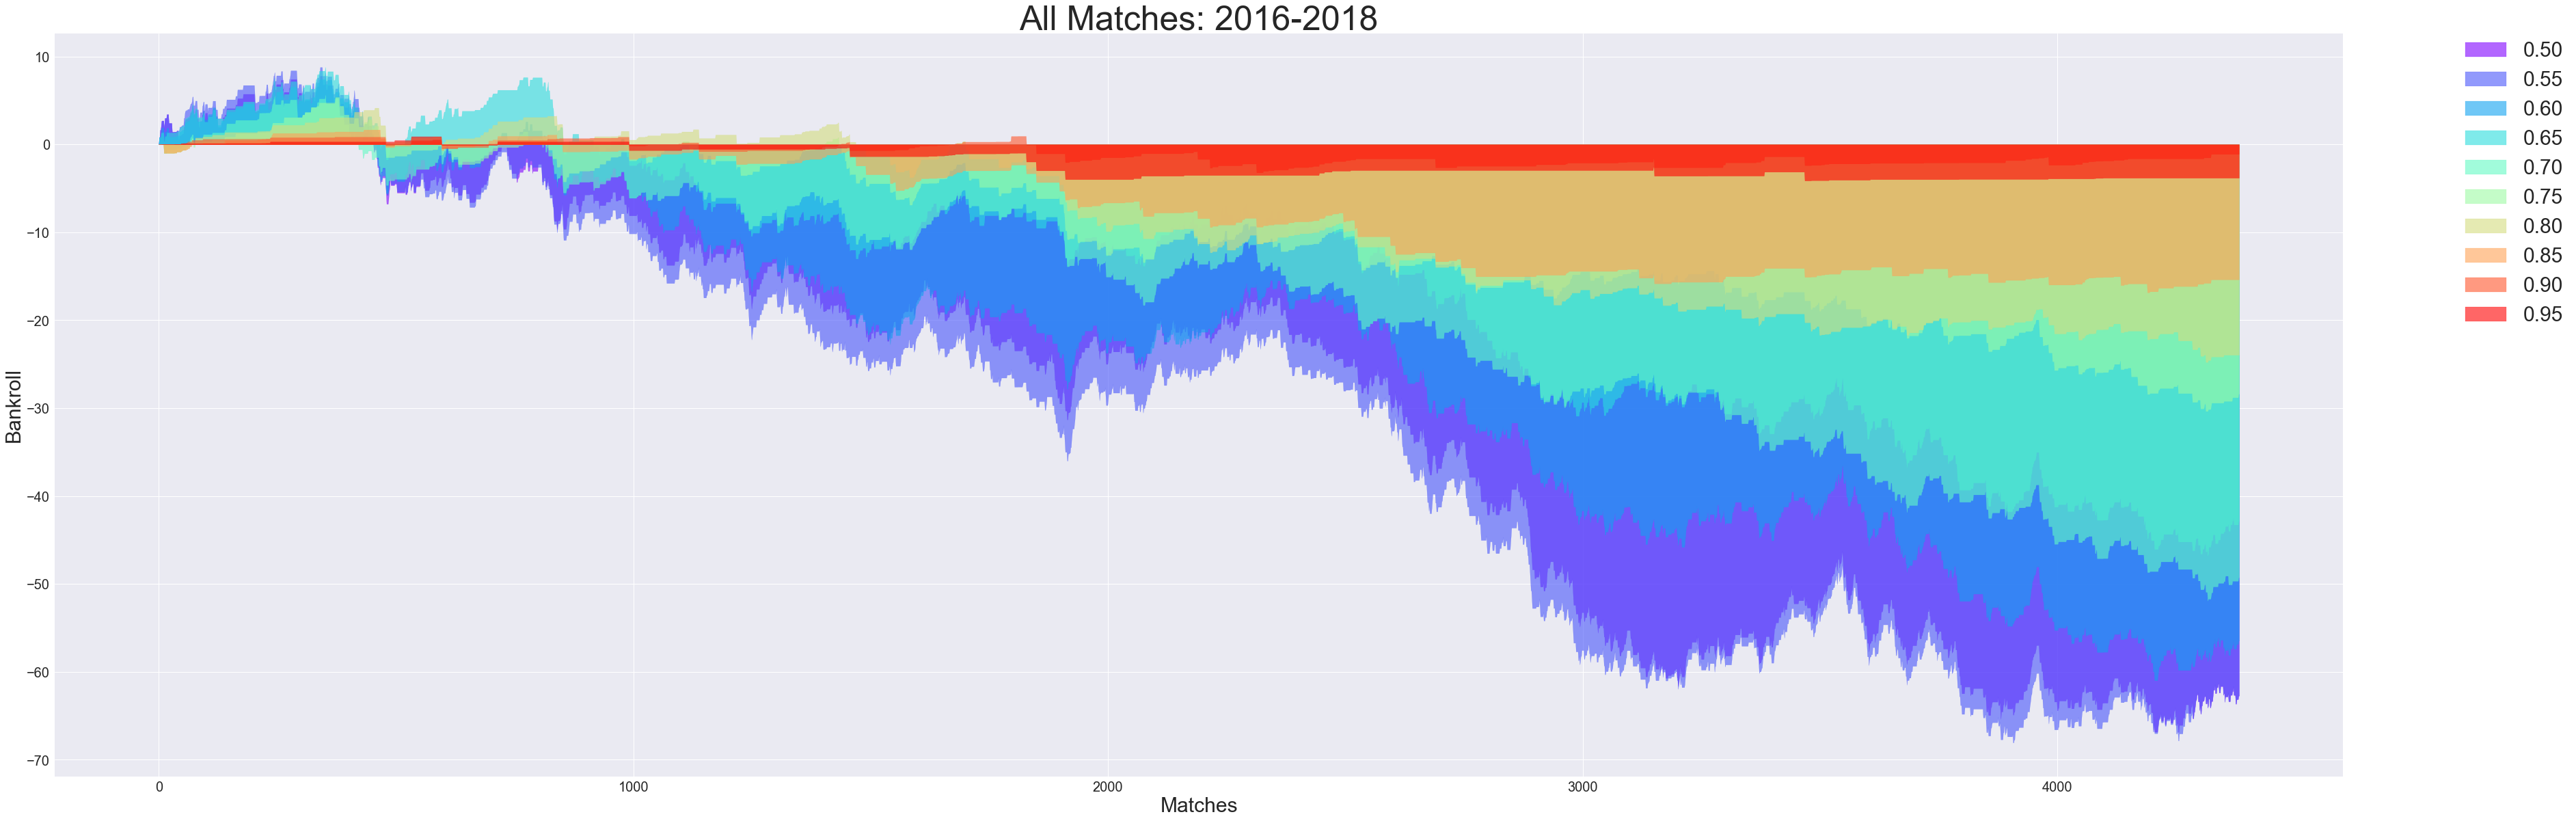

In [91]:
# Betting Setup 
X_test, y_test = get_test_data(test_df)
probas = lr.predict_proba(X_test) # col 0 = player 2 wins,   col 1 = player 1 wins
probas = np.flip(probas, 1)
y_pred = lr.predict(X_test)

plt.figure(figsize=(60, 20))

deltas = np.arange(0, 0.5, .05)
colors = iter(cm.rainbow(np.linspace(0, 1, len(deltas))))

for delta in deltas:
    bankroll, _, _ = oracle_strategy(test_df, probas, delta=delta)
    plt.fill_between(x=range(len(bankroll)), y1=0, y2=bankroll, color=next(colors), alpha=0.6)

    
plt.title("All Matches: 2016-2018", fontsize=50)
plt.xlabel("Matches", fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel("Bankroll", fontsize=30)
plt.yticks(fontsize=20)
plt.legend(['{0:0.2f}'.format(d+0.5) for d in deltas], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=30)
plt.savefig("naive_all_bets.pdf")

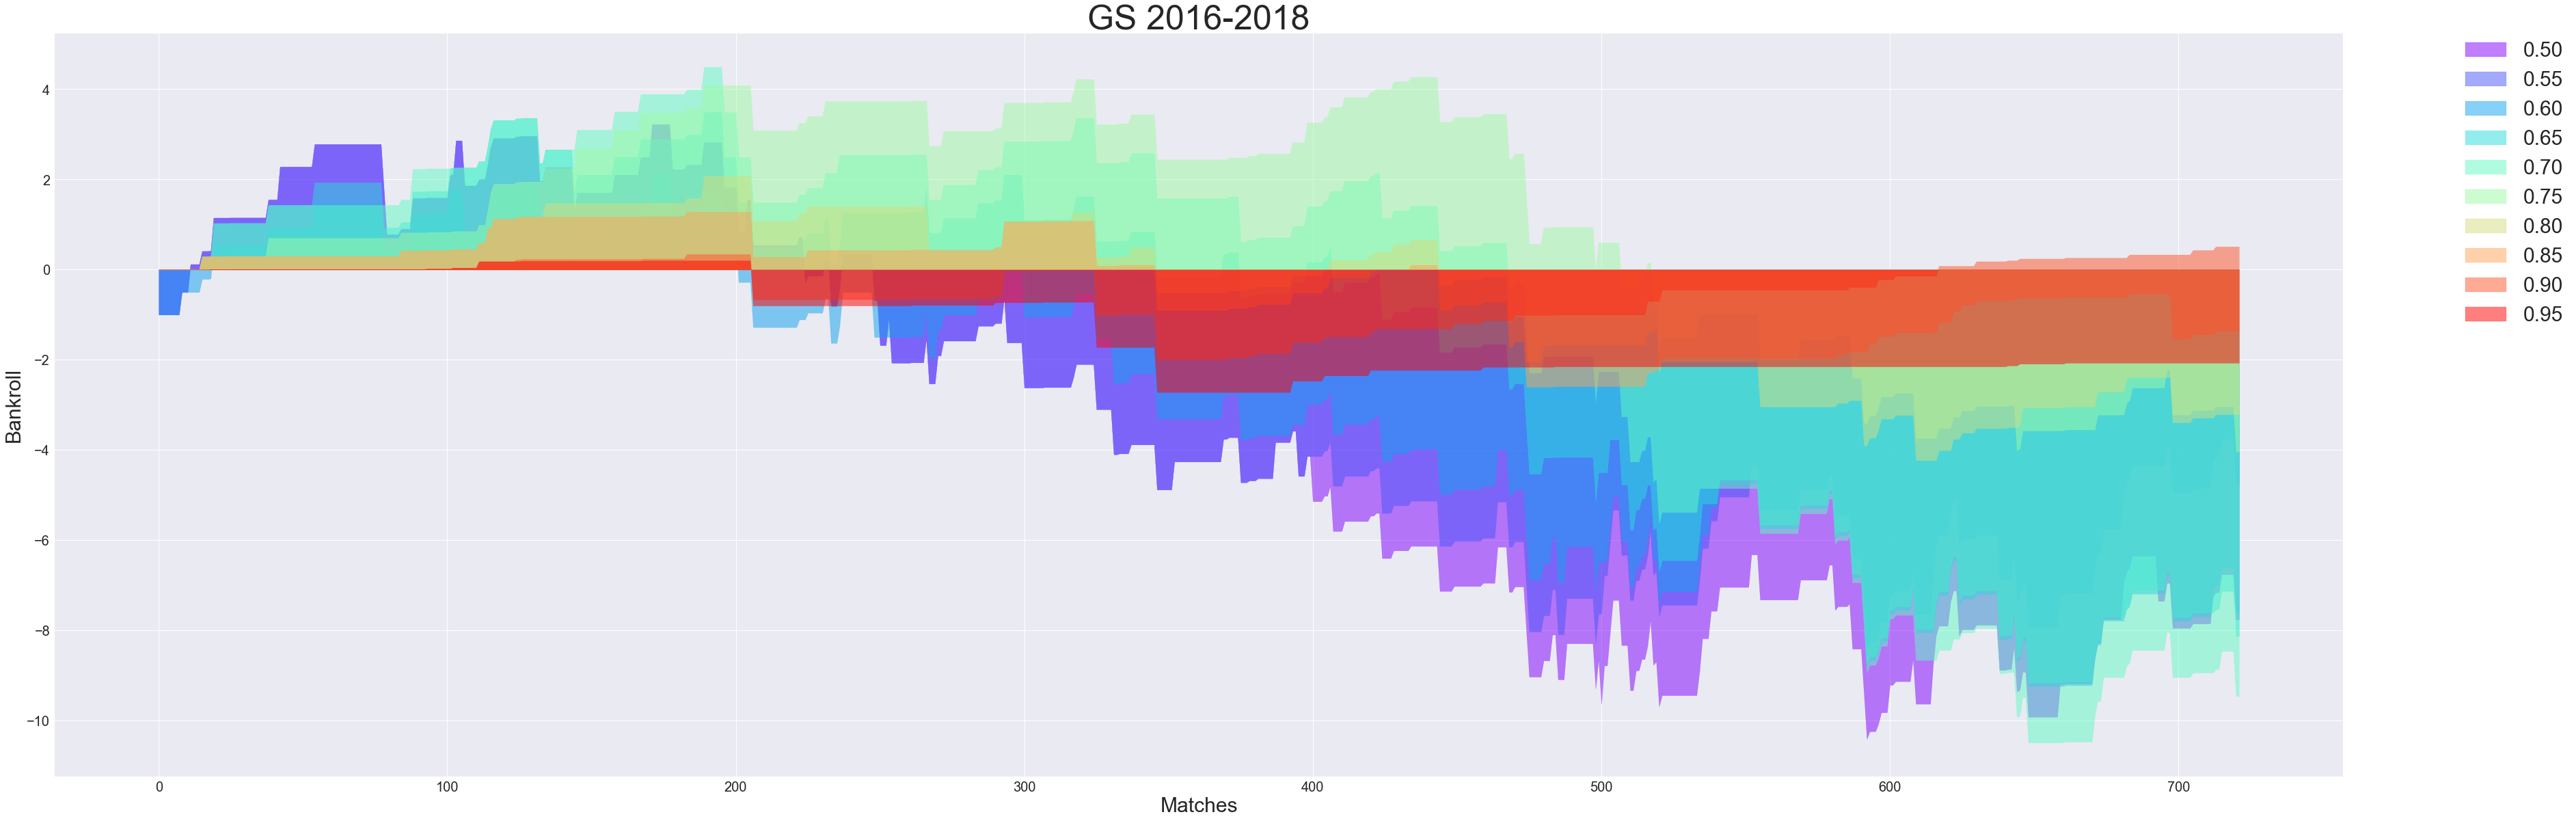

In [95]:
# Only Masters and GS
ms_gs_test_df = test_df[test_df.level.isin(['G'])]

X_test, _ = get_test_data(ms_gs_test_df)
# Probas
probas = lr.predict_proba(X_test) # col 0 = player 2 wins,   col 1 = player 1 wins
probas = np.flip(probas, 1)


plt.figure(figsize=(60, 20))
deltas = np.arange(0, 0.5, .05)
colors = iter(cm.rainbow(np.linspace(0, 1, len(deltas))))



for i, delta in enumerate(deltas):
    bankroll, s, l = oracle_strategy(ms_gs_test_df, probas, delta=delta)
    plt.fill_between(x=range(len(X_test)), y1=0, y2=bankroll, color=next(colors), alpha=0.5)


plt.title("GS 2016-2018", fontsize=50)
plt.xlabel("Matches", fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel("Bankroll", fontsize=30)
plt.yticks(fontsize=20)
plt.legend(['{0:0.2f}'.format(d+0.5) for d in deltas], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=30)
plt.savefig("naive_gs_bets.pdf")

In [15]:
ms_gs_test_df[(ms_gs_test_df.date >= '2017-01-11') & (ms_gs_test_df.date < '2017-05-22') ][['name_1', 'name_2', 'date']]

,name_1,name_2,date
3095,Sam Querrey,Quentin Halys,2017-01-16
3081,Karen Khachanov,Adrian Mannarino,2017-01-16
3082,Dusan Lajovic,Stephane Robert,2017-01-16
3083,Jack Sock,Pierre Hugues Herbert,2017-01-16
3085,Andreas Seppi,Paul Henri Mathieu,2017-01-16
3086,Daniel Evans,Facundo Bagnis,2017-01-16
3090,Alexander Bublik,Lucas Pouille,2017-01-16
3088,Ryan Harrison,Nicolas Mahut,2017-01-16
3089,Tomas Berdych,Luca Vanni,2017-01-16
3094,Steve Johnson,Federico Delbonis,2017-01-16


In [33]:
dates = ('2016-01-01', '2016-05-01','2016-06-20', '2016-08-20', '2017-01-01', '2017-05-22','2017-06-20', '2017-08-20', '2018-01-01', '2018-05-20', '2018-06-20','2018-08-20')


def split_by_tournament(df, dates):
    splits = []
    for i in range(len(dates)):
        date_1 = dates[i]
        if i < len(dates) - 1:
            date_2 = dates[i+1]
            split = df[(df.date >= date_1) & (df.date < date_2)]
            
        else: 
            split = df[(df.date >= date_1)]
        
        if len(split) > 0:
            splits.append((date_1, split))
            
    return splits        

In [34]:
# Only Masters and GS
gs_test_df = test_df[test_df.level.isin(['G'])]
gs_splits = split_by_tournament(gs_test_df, dates)
print([d for d, _ in gs_splits])

['2016-01-01', '2016-06-20', '2017-01-01', '2017-06-20', '2018-01-01', '2018-06-20']


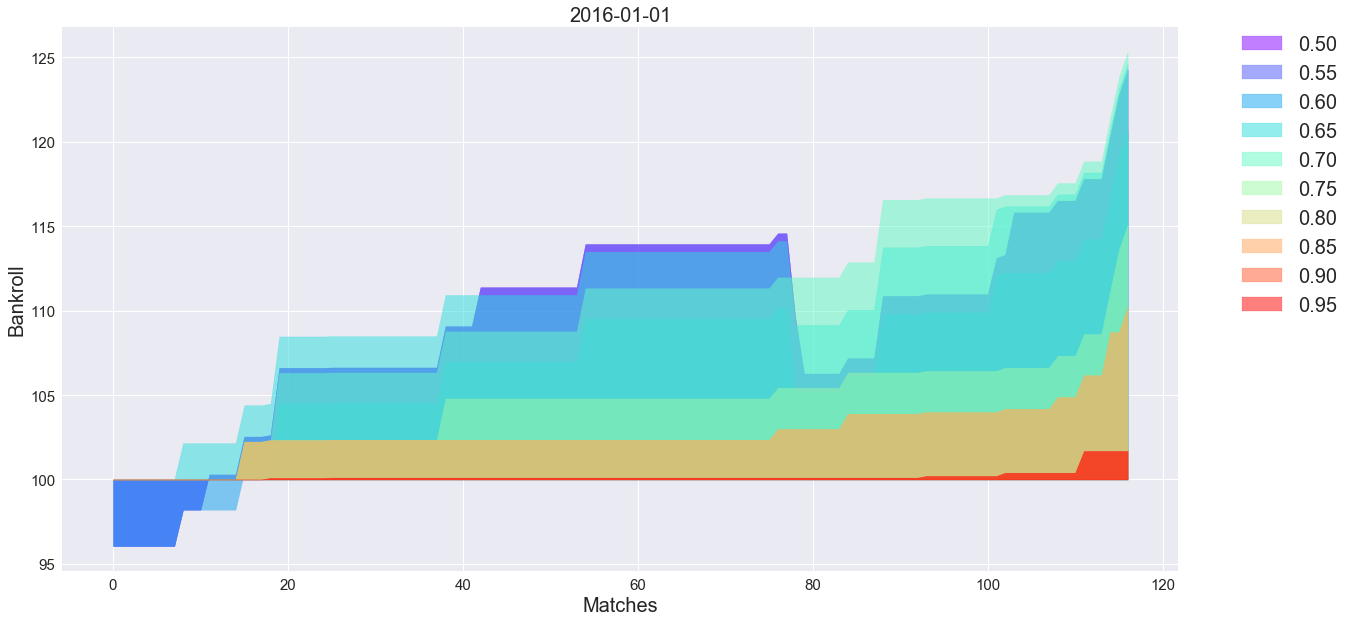

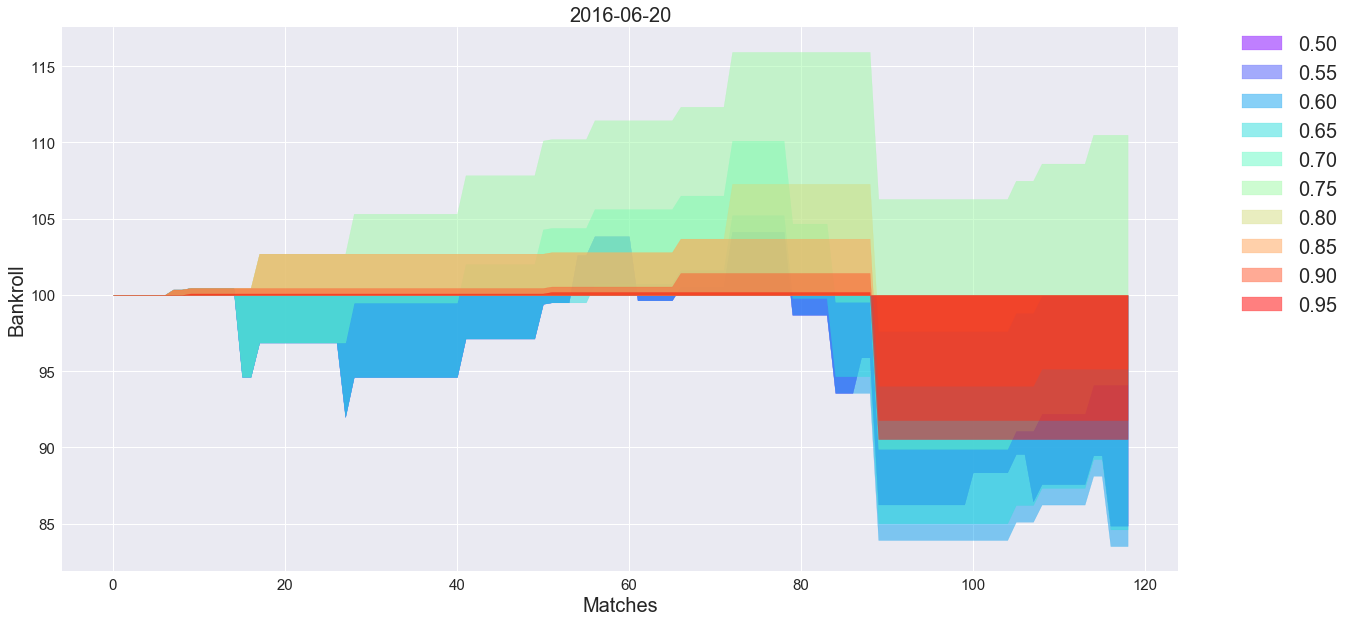

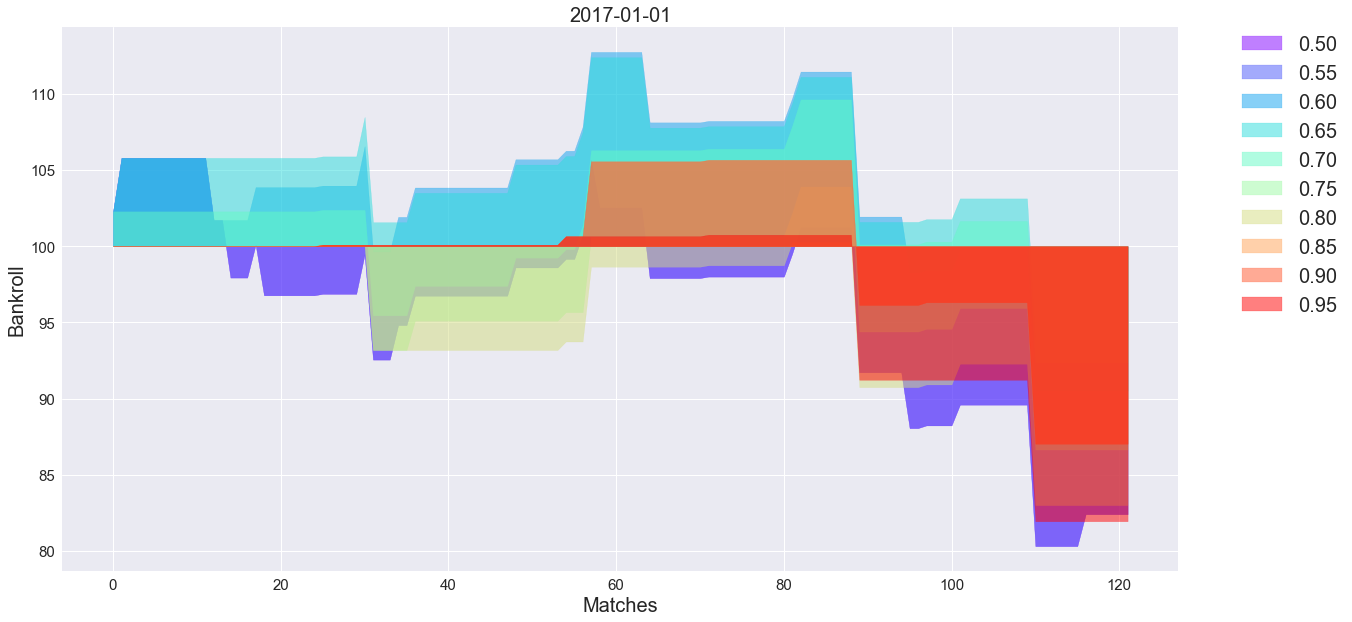

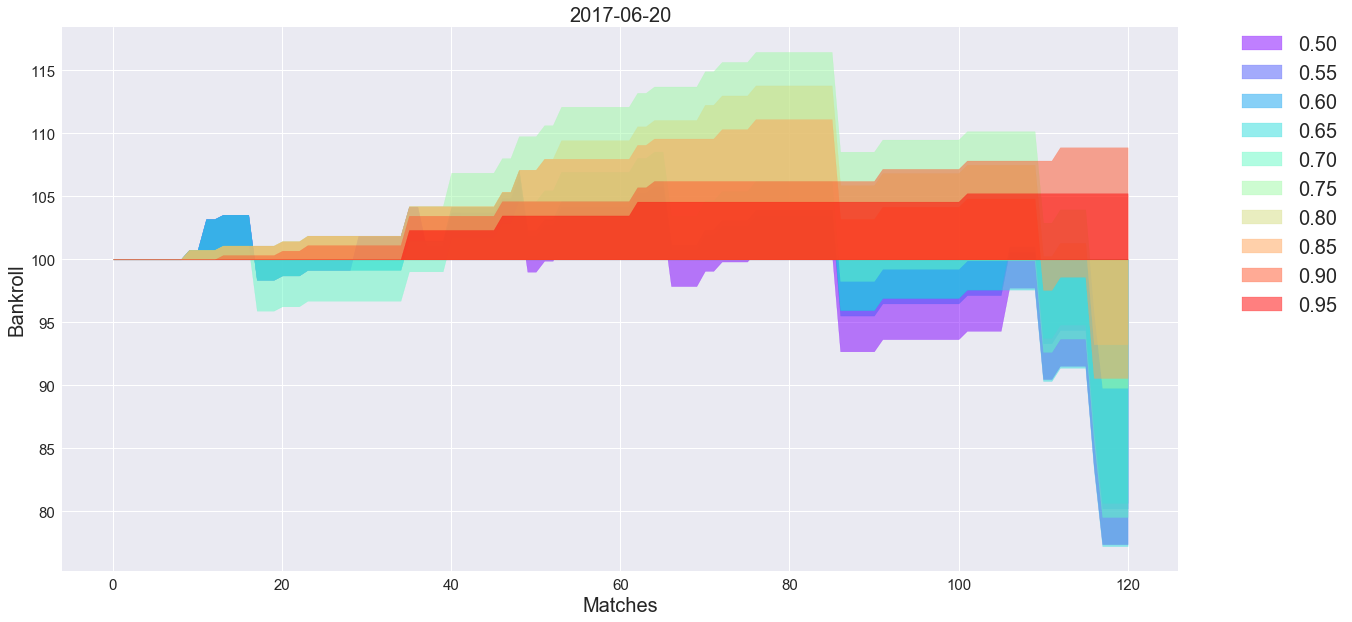

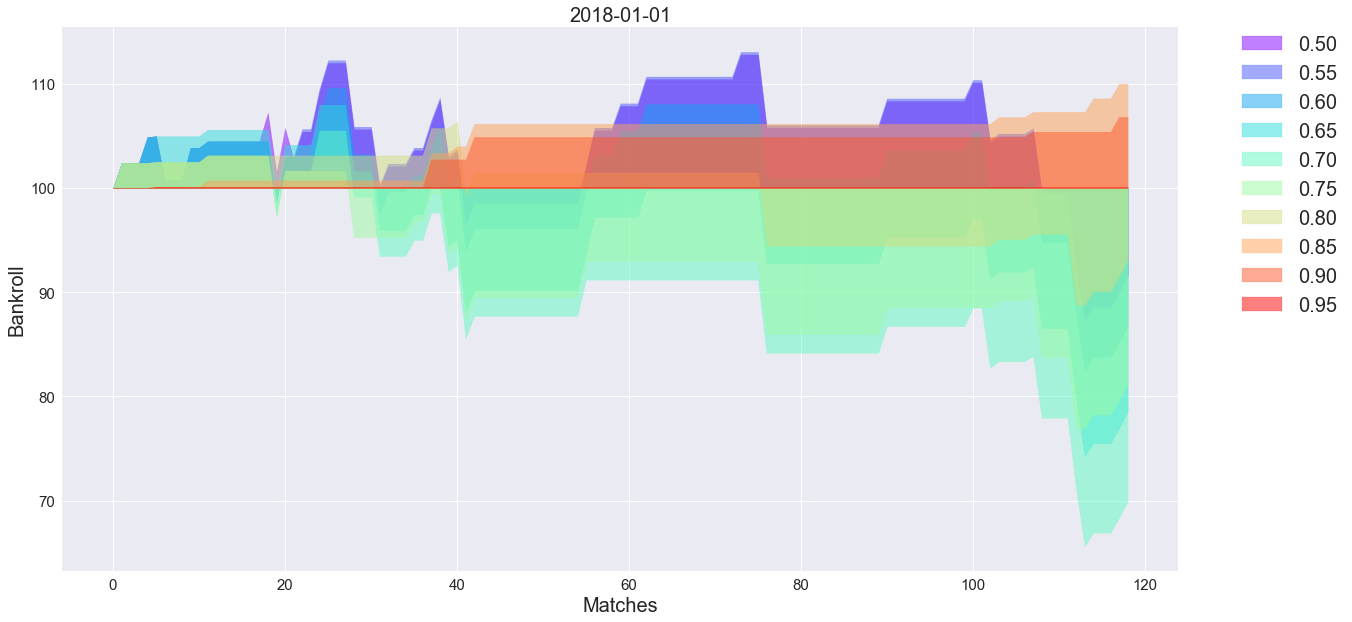

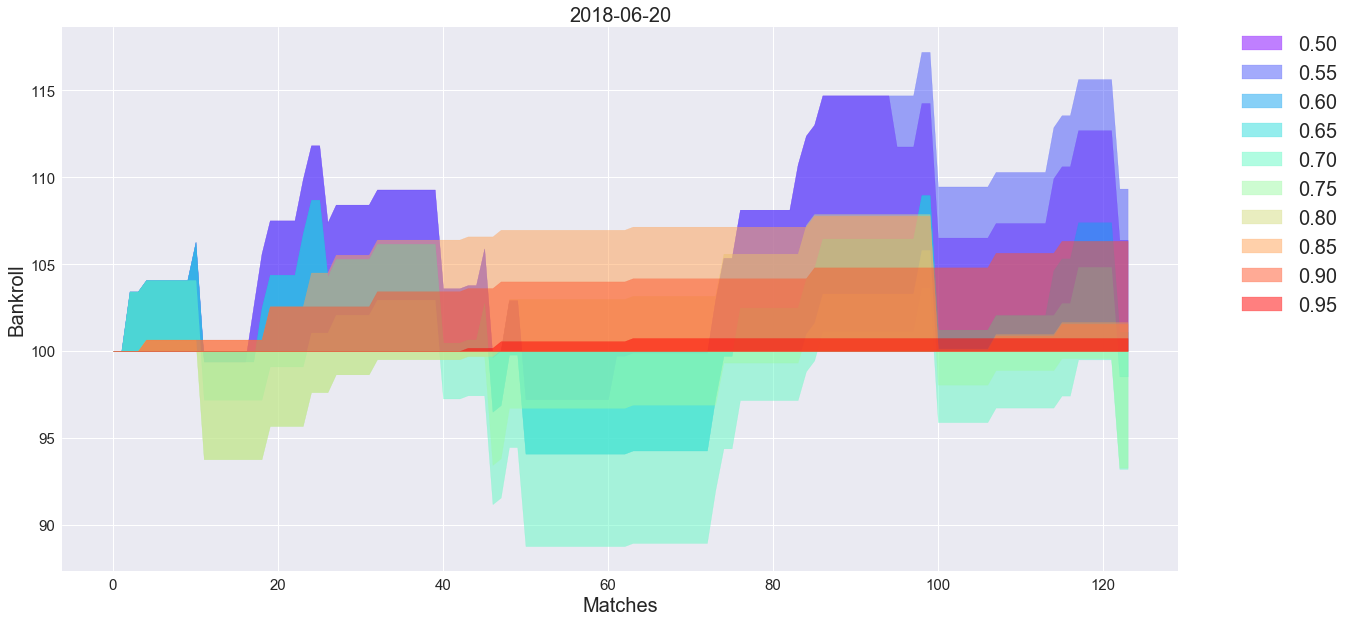

In [98]:
for date, split_df in gs_splits:
    
    from sklearn.linear_model import LogisticRegression
    X_train, y_train = get_training_data(df, date=date)
    lr = LogisticRegression(penalty='l1', max_iter=1000).fit(X_train, y_train)
    
    X_test, _ = get_test_data(split_df)
    # Probas
    probas = lr.predict_proba(X_test) # col 0 = player 2 wins,   col 1 = player 1 wins
    probas = np.flip(probas, 1) # Important !!!


    plt.figure(figsize=(20, 10))
    deltas = np.arange(0, 0.5, .05)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(deltas))))

    for i, delta in enumerate(deltas):
        bankroll, s, l = naive_oracle_strategy(split_df, probas, delta=delta)# constant_stake=1)
        plt.fill_between(x=range(len(X_test)), y1=100, y2=bankroll, color=next(colors), alpha=0.5)

    plt.title(date, fontsize=20)
    plt.xlabel("Matches", fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel("Bankroll", fontsize=20)
    plt.yticks(fontsize=15)
    plt.legend(['{0:0.2f}'.format(d+0.5) for d in deltas], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20)
    plt.savefig(date + "kelly_bets.pdf")
